## Dimensionality Reduction##



## Independent Component Analysis (ICA)

Independent component analysis (ICA) solves the ``cocktail party problem'', where there are multiple microphones situated through out a room containing
$N$ people. Each microphone picks up a linear combination of the $N$
voices. The goal of ICA is to use the concept of statistical
independence to isolate (or unmix) the individual signals. 

Each spectrum, $x_i(k)$, can be described by

>$x_1(k) = a_{11}s_1(k) + a_{12}s_2(k) + a_{13}s_3(k) + \cdots\\
x_2(k) = a_{21}s_1(k) + a_{22}s_2(k) + a_{23}s_3(k) + \cdots \\
x_3(k) = a_{31}s_1(k) + a_{32}s_2(k) + a_{33}s_3(k) + \cdots \\
$

where $s_i(k)$ are the individual  spectra and $a_{ij}$
the appropriate mixing amplitudes. 

In matrix form,
>$ X = A S$,

 Extracting these signal spectra is equivalent to estimating the appropriate weight matrix,
$W$, such that
>$ S = W X$.


Underlying ICA is the observation that the
input signals, $s_i(k)$, should be **statistically
independent** - the joint probability distribution, $f(x,y)$, can be
fully described by  $f(x^p,y^q)=f(x^p)f(y^q)$

 The rationale for ICA is that the
sum of any two independent random variables will always be more
Gaussian than either of the individual random variables (i.e., from the
central limit theorem). If we identify an unmixing matrix, $W$, that
maximizes the non-Gaussianity of the distributions, then we would be
identifying the input signals. 

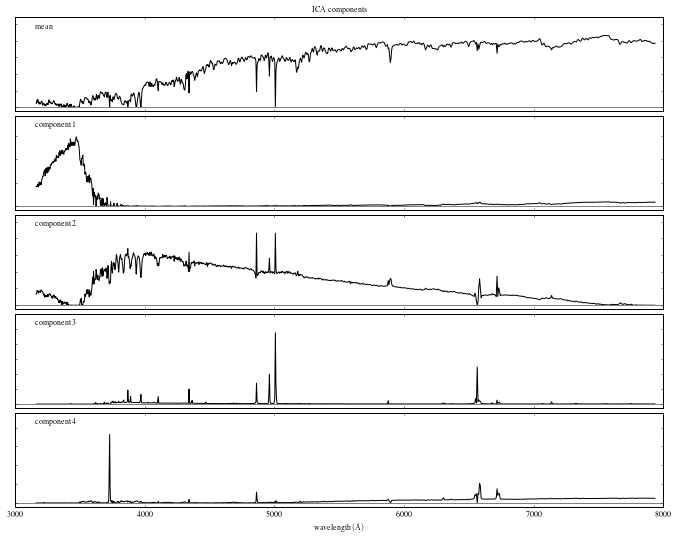

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import FastICA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)


#----------------------------------------------------------------------
# Compute ICA components

def compute_ICA(n_components=5):
    spec_mean = spectra.mean(0)

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, algorithm='deflation')
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    return ica_comp

n_components = 5
decompositions = compute_ICA(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['ICA components',]

for j in range(n_components):
    ax = fig.add_subplot(n_components, 1, j + 1)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

    ax.plot(wavelengths, comp[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles[0])
        label = 'mean'
    else:
        label = 'component %i' % j

    ax.text(0.03, 0.94, label, transform=ax.transAxes, ha='left', va='top')

    for l in ax.get_xticklines() + ax.get_yticklines(): 
        l.set_markersize(2) 

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


plt.show()

## Non negative factorization##

Eigenvectors are defined relative to  mean data vector. Principal components that can be positive or negative but for many physical systems we know data are a linear sum of positive components (e.g. galaxy spectrum is a linear sum of stellar components


Nonnegative matrix factorization (NMF) applies positivity constraint

Assumes  any data matrix can be factored into two matrices, $W$ and $Y$, with
>$\begin{equation}
X=W Y,
\end{equation}
$

and both $W$ and $Y$ are nonnegative 

$WY$ is an approximation of $X$. Minimizing the reconstruction error $|| (X - W Y)^2 ||$ 
nonnegative bases can be derived using a simple update rule (Lee and Seung),
>$
\begin{eqnarray}
W_{ki} &=& W_{ki}\frac{[XY^T]_{ki}}{[WYY^T]_{ki}},\\
Y_{in} &=& Y_{in}\frac{[W^TX]_{in}}{[W^TWY]_{in}},
\end{eqnarray}
$

Iterative process does not guarantee nonlocal minima (like $K$-means and EM). 

Use random initialization and cross-validation 

@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   True
    - kwargs match: True


/Users/ajc/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


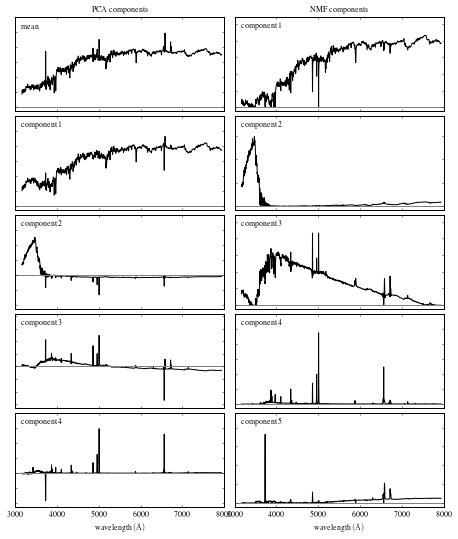

In [18]:
# Author: Jake VanderPlas
# License: BSD
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF
from sklearn.decomposition import RandomizedPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)


#----------------------------------------------------------------------
# Compute PCA, and NMF components
#  we'll save the results so that they can be re-used
@pickle_results('spec_decompositions.pkl')
def compute_PCA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = RandomizedPCA(n_components - 1)
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])


    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 7999]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
        ax.set_xlim(xlim)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines(): 
            l.set_markersize(2) 

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


plt.show()
 

## Manifold Learning##

Real-world data sets often have very nonlinear features (e.g. QSOs with broad lines) which are hard to describe compactly using linear eigenvectors. Manifold learning techniques search for a representation of these data within a lower dimensional space

<img src="http://www.astroml.org/_images/fig_S_manifold_PCA_1.png"></img>

**Local Linear Embedding:**

Step 1: define local geometry
- local neighborhoods determined from $k$ nearest neighbors.
- for each point calculate weights that reconstruct a point from its $k$ nearest
neighbors
>$
\begin{equation}
  \mathcal{E}_1(W) = \left|X - WX\right|^2
\end{equation}
$
- essentially this is finding the hyperplane that describes the local surface at each point within the data set. 

Step 2: embed within a lower dimensional space
- set all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$.  
- $W$ becomes very sparse for $k \ll N$.  
- minimize
>$\begin{equation}
  \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,
\end{equation}
$

with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality)

Step 1 requires a nearest-neighbor search.

Step 2 requires an
eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$,


LLE has been applied to data as diverse as galaxy spectra, stellar spectra, and photometric light curves. 

@pickle_results: computing results and saving to 'spec_LLE.pkl'
 - finished LLE projection
 - removing 33 outliers for plot


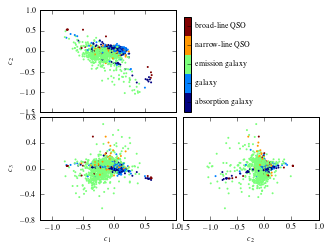

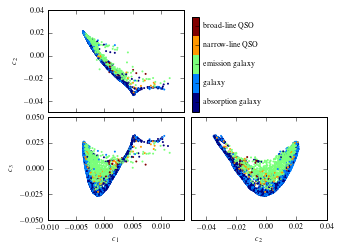

In [21]:
# Author: Jake VanderPlas
# License: BSD
import numpy as np
from matplotlib import pyplot as plt
from sklearn import manifold, neighbors

from astroML.datasets import sdss_corrected_spectra
from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.plotting.tools import discretize_cmap
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Set up color-map properties
clim = (1.5, 6.5)
cmap = discretize_cmap(plt.cm.jet, 5)
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])


#------------------------------------------------------------
# Fetch the data; PCA coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()
coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the LLE projection; save the results
@pickle_results("spec_LLE.pkl")
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors, out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print (" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print (" - removing %i outliers for plot" % flag.sum())

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 3)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_LLE],
                             [coeffs_PCA, coeffs_LLE],
                             [(-1.2, 1.0), (-0.01, 0.014)]):
    fig = plt.figure(figsize=(5, 3.75))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()
 